Example of using cppyy for bridging C++ code to Python
===

The code below uses:
* [cppyy](https://cppyy.readthedocs.io/en/latest/index.html)
* [ctypes](https://docs.python.org/3/library/ctypes.html)
* [numpy](https://numpy.org/)
* [Pillow](https://pypi.org/project/Pillow/)
* [timeit](https://docs.python.org/3/library/timeit.html)

Note: in the first cell we import ROOT, then cppyy.  This is only necesary in an evironment like phys56xx where both packages are installed.  In an environment w/o ROOT, just import cppyy.  The code that follows is generic to using cppyy.

**CAVEAT**:  If I haven't mentioned it enough times, I'll do so again just in case... I do not recommend developing code in the notebook.  Notebooks are good for working with functions and classes in prebuit libraries and for prototyping things, but using them for writing larger amounts of code, expecially C/C++ will greatly slow down your develpment cycle.  Note that if you run the cppyy.cppdef insrtructions a second time, you'll get errors b/c C++ does not allow your to redefine classes or functions.  To change the compiled code you'll have to restart the kernel.  This is not very convenient, so I recommend making libraries and linking this in a shown below.

In [ ]:
import ROOT as r  # not used, but we need to import this to use cppyy in our hybrid environment
import cppyy      # only this line is needed if ROOT is not installed in your environment

We now have a just-in-time C++ compiler that is callable from Python.  It's cool, but don't over use it when you can build libraries instead for larger projects.

From the docs: *cppyy is based on Cling, the C++ interpreter, to match Python’s dynamism, interactivity, and run-time behavior*

Example 1: defining and compiling a C++ class 
---

In [ ]:
cppyy.cppdef("""
class MyClass {
public:
    MyClass(int i) : m_data(i) {}
    virtual ~MyClass() {}
    virtual int add_int(int i) { return m_data + i; }
    int m_data;
};""")

In this case the interfaces to the C++ code are automatically defined.  There is no need to define argtypes/restype, so we can use our C++ class directly below.

In [ ]:
from cppyy.gbl import MyClass
m = MyClass(42) # C++ class in Python!

We can even dynamically mix C++ and Python in various ways.  Below we add a new method to the class that is visible from the Python side.

In [ ]:
cppyy.cppdef("""
void say_hello(MyClass* m) {
    std::cout << "Hello, the number is: " << m->m_data << std::endl;
}""")

In [ ]:
MyClass.say_hello = cppyy.gbl.say_hello
m.say_hello()

Example 2: defining a C++ function
----

In [ ]:
cppyy.cppdef("""
// estimate pi from the dart throwing method
double findPi2(long nthrows=100*1000*1000){
  srand48((long)time(NULL));
  long count=0;
  for (int i=0; i<nthrows; ++i){
    double x=drand48();
    double y=drand48();
    if (x*x+y*y < 1) ++count;
  }
  return 4.0*count/nthrows;
}""")

In [ ]:
%time PI=cppyy.gbl.findPi2(100*1000*1000)
print("Estimate for pi:",PI)

This is close to what we saw in the previous example. Next we'll look at an example of

Loading libraries with cppyy
---

In general it is very awkward developing C++ code as text string in the middel of a Python program.  It's fine to do this for short fucntions where you can achieve a quick speed boost.  But for substantial amounts of code you'll want to compile your code into shared libraries.  You can test the code in the libraries by calling classes/functions from a dedicated C++ program or using a Python script.

The Makefile created a version of mylib with C++ style linkage, mylib.so.  We can load this via cppyy as shown below.  Notice that we inclulded the header file for the library.  cppyy uses this to automatically build our interfaces!!!  This is really great.  Using the recipie in the Makefile you can easily make an enourmous range of  C++ code available in Python.  Some extra effort is required if you want to pass more complex data types, but with cppyy you can go a very long way in bridging the two languages with little effort.

In [ ]:
cppyy.include('mylib.h')
cppyy.load_library('mylib.so')
mandel=cppyy.gbl.mandel  # make a convenient handle to access our class

In [ ]:
import numpy as np
# define parameters for the calulation
npX=2000   # 2000 x 2000 pixel image
npY=2000
nTrials=255
re1=-2.1
re2=0.6
im1=-1.5
im2=1.5
img=np.ndarray(shape=(npX,npY), dtype=np.double) # array to hold our image

In [ ]:
%time mandel(img,re1,re2,im1,im2,npX,npY,nTrials)

In [ ]:
from PIL import Image

# convert values to 0 - 255 int8 format
img=np.log(img)
img = (img/img.max()*255).astype('uint8')
image = Image.fromarray(img)

display(image)

The amazing benefit of cppyy is that it can automatically builds interfaces for a wide range of C++ objects including standard containers, like vectors.  It's not difficult to map containiers in Python like numpy arrays or numerical arrays from the Python array module to C++ counterparts and it's usually possible to find useful examples in the cppyy documentation or by strategic web searching, consulting a friendly AI, etc.  If you are using ROOT objects, extensions to cppyy in ROOT are provided to make the interface of C++ ROOT and Python objects very easy.

In the example below, we'll use a C++ class to perform the calculation above.  Refer to the code in mycpplib.cpp(h).

In [ ]:
cppyy.include('mycpplib.h')
cppyy.load_library('mycpplib.so')
Mandel=cppyy.gbl.Mandel  # make a convenient handle to access our class

Let's see what we have here. Including automatically generated doc strings for the C++ code.

In [ ]:
type(Mandel)

cppyy does a lot of work to conveniently pythonize our C++ class!

In [ ]:
help(Mandel)

In [ ]:
print(Mandel.mandel_test.__doc__)

In [ ]:
mymandel=Mandel()
from ctypes import c_double, c_int, POINTER
re1=c_double()
re2=c_double()
im1=c_double()
im2=c_double()
mymandel.getRange(re1,re2,im1,im2)  # look at the default range
print(f'range to explore: [{re1.value},{im1.value}] to [{re2.value},{im2.value}]')
nr=c_int()
ni=c_int()
mymandel.getResolution(nr,ni)
print(f'resolution: {nr.value}x{ni.value}')

In [ ]:
mymandel.calculate()

In [ ]:
import numpy as np
img=np.ndarray(shape=(nr.value,ni.value), dtype=np.double) # array to hold our image
mymandel.getImg(img.ctypes.data_as(POINTER(c_double)))

In [ ]:
from PIL import Image

# convert values to 0 - 255 int8 format
img=np.log(img)
img = (img/img.max()*255).astype('uint8')
image = Image.fromarray(img)

display(image)

In [ ]:
mymandel.setRange(-.8,-.7,0,.2)  
mymandel.getRange(re1,re2,im1,im2)  # look at the default range
print(f'range to explore: [{re1.value},{im1.value}] to [{re2.value},{im2.value}]')

Quiz for you:  Why do we have to recreate the img array below before retrieving the new scan? 

In [ ]:
mymandel.calculate()
img=np.ndarray(shape=(nr.value,ni.value), dtype=np.double) # array to hold our image
mymandel.getImg(img.ctypes.data_as(POINTER(c_double)))

In [ ]:
img=np.log(img)
img = (img/img.max()*255).astype('uint8')
image = Image.fromarray(img)
display(image)

Homework project
=================

**Work on this AFTER examining all of the examples presented in today's class**

Project 3a
----------
Examine the Python code below.  Modify mycpplib to include a C++ version of this code.  Then produce a plot showing the ratio of the time required to perform the calculation in the two languages (Python/C++) versus the input number *n*.  Extend your plot to at least n=2500.

In [2]:
def count3d(n):
    count=0
    for i in range (n):
        for j in range (i+1,n):
            for k in range (j+1,n):
                count = count +1
    return count

count3d(1)  # we call the funfion once to generate the bytecode before the timing trials 

0

Below we use the [timeit module](https://docs.python.org/3/library/timeit.html) instead of the cell magick %time.  This allow us to retrieve the time in a Python variable.
Note: computer timers have limited accuracy, therefore you may observe large fractional fluctuations for small times.  The estimate can be improved by averaging over several calls to the code.  Be aware of this, but you don't need to be very accurate in measuring the small times for this project, the case for large *n* is the most interesting region!

In the example below timeit executes the count3d function with n=10.  In this examples the calculation is repeated number=1 times in a trial.  By default 5 trials are run and the best time is reported.  See the timeit documentation for more information.

**Your code and plot goes here**

In [3]:
#%time count3d(ncount)

ncount=10
import timeit
execTime=timeit.timeit(f'count3d({ncount})', number=1, globals=globals())
print(f'execution time = {execTime} seconds')

execution time = 9.648007107898593e-06 seconds


In [4]:
timeit.timeit(f'count3d({ncount})', number=1, globals=globals())

9.512994438409805e-06

n= 100 | py=0.004263s  C=0.000005s  ratio=910.02
n= 200 | py=0.032764s  C=0.000017s  ratio=1907.87
n= 400 | py=0.317318s  C=0.000068s  ratio=4692.39
n= 600 | py=1.104769s  C=0.000150s  ratio=7347.00
n= 800 | py=2.629502s  C=0.000267s  ratio=9847.36
n=1200 | py=8.923150s  C=0.000605s  ratio=14738.65
n=1600 | py=21.288285s  C=0.001071s  ratio=19875.01
n=2000 | py=44.283104s  C=0.001675s  ratio=26442.95
n=2500 | py=91.145558s  C=0.002619s  ratio=34799.33


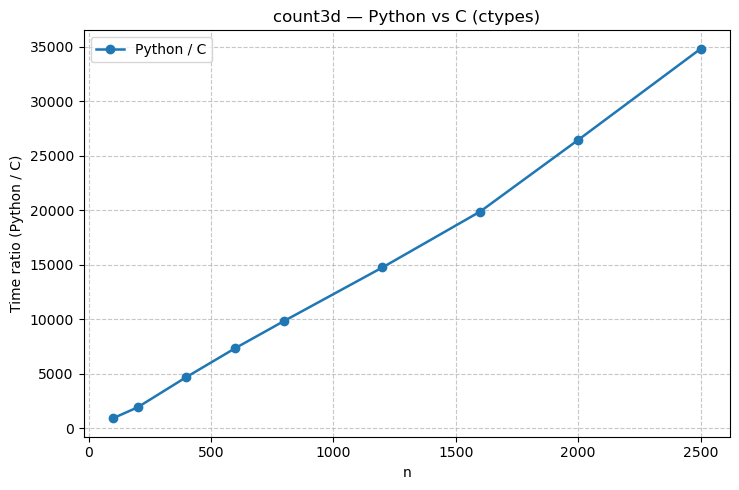

In [5]:
import ctypes, timeit, matplotlib.pyplot as plt
lib = ctypes.CDLL('./mycpplib.so')
lib.count3d_c.argtypes = [ctypes.c_int]
lib.count3d_c.restype  = ctypes.c_longlong

def best_time(stmt, glb, number=1, repeat=3):
    t = timeit.Timer(stmt, globals=glb)
    return min(t.repeat(repeat=repeat, number=number)) / number

ns_all = [100, 200, 400, 600, 800, 1200, 1600, 2000, 2500]
NS_PY_CAP = 2500

_ = count3d(50)
_ = lib.count3d_c(50)

ratios = []
for n in ns_all:
    tc = best_time(f'lib.count3d_c({n})', globals(), number=1, repeat=3)
    if n <= NS_PY_CAP:
        tp = best_time(f'count3d({n})', globals(), number=1, repeat=3)
        ratios.append((n, tp/tc))
        print(f"n={n:4d} | py={tp:.6f}s  C={tc:.6f}s  ratio={tp/tc:.2f}")
    else:
        print(f"n={n:4d} | C={tc:.6f}s  py=SKIP")

xs = [n for n, r in ratios]
ys = [r for _, r in ratios]
plt.figure(figsize=(7.5,5.0))
plt.plot(xs, ys, marker='o', linewidth=1.8, label='Python / C')
plt.xlabel('n'); plt.ylabel('Time ratio (Python / C)')
plt.title('count3d — Python vs C (ctypes)')
plt.grid(True, linestyle='--', alpha=0.7); plt.legend(); plt.tight_layout()
plt.savefig('proj3a_ratio_py_c.png', dpi=200, bbox_inches='tight'); plt.show()


Project 3b
----------
Repeat the exerise now comparing the ties using C++ and numba (C++/numba).

**Your code and plot goes here**

n= 100 | C=0.000005s  Numba=0.000001s  ratio=9.23
n= 200 | C=0.000017s  Numba=0.000001s  ratio=26.94
n= 400 | C=0.000067s  Numba=0.000001s  ratio=73.09
n= 600 | C=0.000150s  Numba=0.000001s  ratio=124.00
n= 800 | C=0.000267s  Numba=0.000002s  ratio=176.94
n=1200 | C=0.000601s  Numba=0.000002s  ratio=282.41
n=1600 | C=0.001071s  Numba=0.000003s  ratio=391.53
n=2000 | C=0.001672s  Numba=0.000003s  ratio=502.04
n=2500 | C=0.002616s  Numba=0.000004s  ratio=644.89


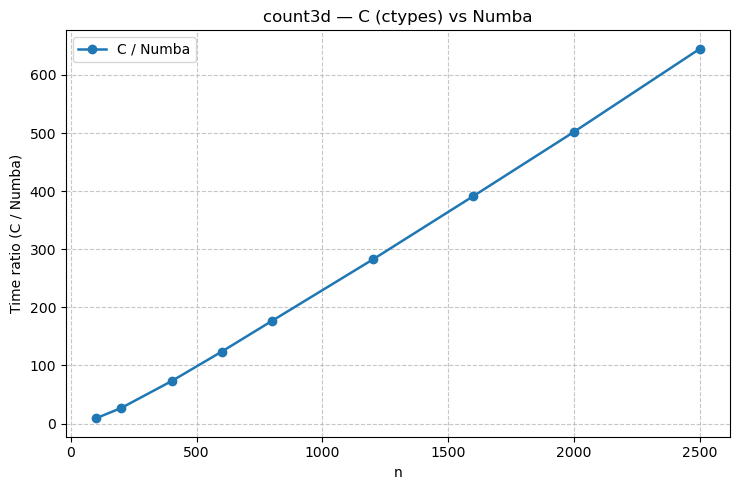

In [6]:
import ctypes, timeit, matplotlib.pyplot as plt
from numba import njit
lib = ctypes.CDLL('./mycpplib.so')
lib.count3d_c.argtypes = [ctypes.c_int]
lib.count3d_c.restype  = ctypes.c_longlong

@njit(cache=True)
def count3d_numba(n: int) -> int:
    cnt = 0
    for i in range(n):
        for j in range(i + 1, n):
            cnt += (n - (j + 1))
    return cnt

_ = count3d_numba(50)
_ = lib.count3d_c(50)

def best_time(stmt, glb, number=1, repeat=3):
    t = timeit.Timer(stmt, globals=glb)
    return min(t.repeat(repeat=repeat, number=number)) / number

ns = [100, 200, 400, 600, 800, 1200, 1600, 2000, 2500]
rat = []
for n in ns:
    tc = best_time(f'lib.count3d_c({n})', globals(), number=1, repeat=3)
    tn = best_time(f'count3d_numba({n})', globals(), number=1, repeat=3)
    rat.append(tc/tn)
    print(f"n={n:4d} | C={tc:.6f}s  Numba={tn:.6f}s  ratio={tc/tn:.2f}")

plt.figure(figsize=(7.5,5.0))
plt.plot(ns, rat, marker='o', linewidth=1.8, label='C / Numba')
plt.xlabel('n'); plt.ylabel('Time ratio (C / Numba)')
plt.title('count3d — C (ctypes) vs Numba')
plt.grid(True, linestyle='--', alpha=0.7); plt.legend(); plt.tight_layout()
plt.savefig('proj3b_ratio_c_numba.png', dpi=200, bbox_inches='tight'); plt.show()
